In [2]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import csv
import pandas as pd

import urllib.request,sys,time
from bs4 import BeautifulSoup, UnicodeDammit
import requests
from matplotlib import pyplot as plt
import os

from wordcloud import WordCloud
import pdfplumber
import re
from scipy.special import softmax
import numpy as np
import base64
import io

d:\Documents\Github\hugging-face\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## CNA sample article urls
# url = "https://www.channelnewsasia.com/sustainability/scientists-discover-how-air-pollution-triggers-lung-cancer-2931111"
# url = "https://www.channelnewsasia.com/asia/indonesia-subsidised-fuel-price-increase-micro-businesses-2929006"
url = "https://www.channelnewsasia.com/singapore/nightclub-operator-club-posh-west-palace-entertainment-evade-gst-money-laundering-jailed-penalty-2935436"
# url = "https://cnaluxury.channelnewsasia.com/people/chye-seng-huat-hardware-leon-foo-morning-coffee-machine-206531"

In [4]:
## convert CNA url -> HTML -> CSV
def extract_csv_from_html(url):
    try:
        page=requests.get(url) 
    except Exception as e:    
        error_type, error_obj, error_info = sys.exc_info()      
        print ('ERROR FOR LINK:',url)                     
        print (error_type, 'Line:', error_info.tb_lineno)

    time.sleep(2)
    soup = BeautifulSoup(page.text, "html.parser")


    ## extract article content
    textContent = soup.find_all('div', attrs={'class':'text'})
    paragraphs = []

    for i in textContent:
        para = i.find_all('p')
        for j in para:
            content = j.getText().strip()
            paragraphs.append(content)

    df = pd.DataFrame(paragraphs)
    df.to_csv("backend/data/news.csv", index=False)


message = extract_csv_from_html(url)

In [5]:
## convert cna url -> html -> txt
def extract_txt_from_html(url):
    try:
        page=requests.get(url) 
    except Exception as e:    
        error_type, error_obj, error_info = sys.exc_info()      
        print ('ERROR FOR LINK:',url)                     
        print (error_type, 'Line:', error_info.tb_lineno)

    time.sleep(2)
    soup = BeautifulSoup(page.text, "html.parser")

    ## extract article title
    title = soup.find('h1',attrs={'class':'h1 h1--page-title'}).getText()

    ## extract article content
    textContent = soup.find_all('div', attrs={'class':'text'})
    paragraphs = []

    for i in textContent:
        para = i.find_all('p')
        for j in para:
            content = j.getText().strip()
            paragraphs.append(content)

    single_para = "".join(paragraphs)
    # lines = "\n".join(paragraphs)
    # multi_para = "\n".join(paragraphs)

    f = open("backend/data/article.txt", "w+")
    f.write(single_para)
    f.close()

message = extract_txt_from_html(url)

Text Pre-processing

In [6]:
# extracts content from csv/txt in /data to an entire paragraph
def extract_text(filename):
    message = ""
    name, extension = os.path.splitext(filename)
    try: 
        if extension == ".csv":   # csv format
            with open("backend/data/{}".format(filename), 'r', encoding="utf8") as f:
                reader = csv.reader(f)
                next(reader, None)  # skip headers
                for row in reader:
                    # print(row)    
                    message += "".join(row)
                # print(sentences)
        elif extension == ".txt":     # txt format
            with open("backend/data/{}".format(filename), 'rb') as f:
                byteString = f.read()
                dammit = UnicodeDammit(byteString, ["utf-8",  "ascii"])
                encoding = dammit.original_encoding
                print("Encoding Type:", encoding)
                message = byteString.decode(encoding, errors='ignore')
                # print(message)
            
        elif extension == '.pdf':
            with pdfplumber.open("backend/data/{}".format(filename)) as pdf:
                for page in pdf.pages:
                    message += page.extract_text() 
    except Exception as err:
            print(err, "occured in"+filename)
    message = message.replace('\n|\\x92"|\\x93|\\x94', ' ') # replace common unicode chars
    return message

# split text > max_length into a list of sentences
def form_text_chunks(document, max_length):
    chunks = []
    sent = ""
    length = 0
    for sentence in document:
        # print(sentence + "\n")
        sentence +=  "."
        length += len(sentence)
        if length < max_length:
            sent += sentence
        else:
            # print(sent + "\n\n")
            chunks.append(sent)
            sent = ""
            length = 0
    if sent:
        chunks.append(sent)
    return chunks

NLP Methods

In [7]:
# summarizes entire paragraph and exports as JSON
def summarize(summarizer, chunks):
    result = ""
    for i in chunks:
        summarized = summarizer(i, max_length=70, min_length=30, do_sample=False)
        # print(summarized[0]["summary_text"])
        result += summarized[0]["summary_text"]
    # print(result)
    return result

def generate_summary(messageJson):
    # Summarization model
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn", tokenizer="facebook/bart-large-cnn")
    message = messageJson["text"]
    sentences = message.split('.')
    chunks = form_text_chunks(sentences, 1024)
    # print("chunks:", chunks)
    summary = summarize(summarizer, chunks)
    # print(result + "\n")
    while (len(summary) > 1200):
        sentences = summary.split('.')
        chunks = form_text_chunks(sentences, 1024)
        summary = summarize(summarizer, chunks)
    print(summary)
    returnJson = {"summary": summary}
    # print("ReturnJSON:", returnJson)
    return returnJson


### TEST CODE
test_filename = "article.txt"
text = extract_text(test_filename)
num_words = len(text.split(' '))
print("Total wordcount:", num_words)
requestJson = {"text": text}
summarizedJson = generate_summary(requestJson)

Encoding Type: windows-1252
Total wordcount: 406
Soon Kok Khoon was found to have helped the clubs make false entries in their GST returns “with wilful intent" to evade the tax. He was convicted of three counts of GST evasion and ordered to pay a penalty of S$630,861. Five other charges were also taken into consideration for the sentencing.Soon also instructed his staff to divert the sales revenue of the clubs, which were GST-registered, to two shell entities using separate point-of-sale terminals. Customers would buy these flower garlands, priced between S$50 and S$100,000, at the clubs.Anyone who acquires, possesses, uses, conceals or transfers benefits from criminal conduct could be fined up to S$500,000, jailed up to 10 years, or both.


In [8]:
def generate_sentiments(messageJson):
    # sentiment analysis model
    model = "cardiffnlp/twitter-roberta-base-sentiment"
    tokenizer = AutoTokenizer.from_pretrained(model)
    model = AutoModelForSequenceClassification.from_pretrained(model)
    
    labels=['negative', 'neutral', 'positive']

    message = messageJson["text"]
    texts = message.split('.')
    chunks = form_text_chunks(texts, 512)
    
    scores_table = []
    sentimentJson = {"overall_score":{}, "overall_sentiment": "none", "sentiment_count":{}}
    sentiment_count = {"negative": 0, "neutral": 0, "positive": 0}
    for index in range(len(chunks)):
        text = chunks[index]
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().tolist()
        scores = softmax(scores)    # converts into probabilities
        
        scores_table.append(scores)
        pred_sentiment = labels[np.argmax(scores)]
        sentiment_count[pred_sentiment] += 1
        # print(sentiment_count)

        
    # calculate overall average sentiment       
    np_scores = np.asarray(scores_table)
    # print((np_scores))
    avg_sentiments = np.round(np.average(np_scores, axis=0), 4)
    for index in range(len(avg_sentiments)):
        sentiment = labels[index]
        sentimentJson["overall_score"][sentiment] = avg_sentiments[index]
    sentimentJson["overall_sentiment"] = labels[np.argmax(avg_sentiments)]
    sentimentJson["sentiment_count"] = sentiment_count
    print(sentimentJson)
    return sentimentJson

### TEST CODE
test_filename = "sample_news.csv"
text = extract_text(test_filename)
num_words = len(text.split(' '))
num_sent = len(text.split('.'))
print("Total wordcount:", num_words)
print("Total sentences:", num_sent)
requestJson = {"text": text}
sentimentJson = generate_sentiments(requestJson)

Total wordcount: 751
Total sentences: 36
{'overall_score': {'negative': 0.3214, 'neutral': 0.4179, 'positive': 0.2607}, 'overall_sentiment': 'neutral', 'sentiment_count': {'negative': 4, 'neutral': 3, 'positive': 2}}


Total wordcount: 751
Total sentences: 36


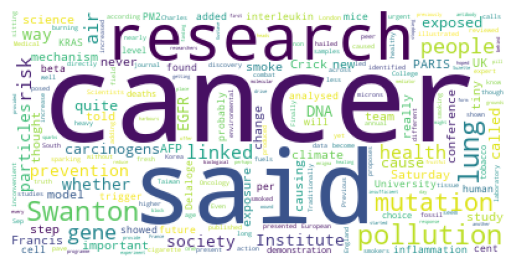

{'data': 'iVBORw0KGgoAAAANSUhEUgAAAZAAAADICAIAAABJdyC1AAEAAElEQVR4nOy9dXjc1rY+vCQNM3jMzOzYYWZO2jTQlDHl9pQx7Sn3lJm5KaZJ2yQNM7PtmJlxmFnw/SFnPB7PjMeO03Pv77vv42e8tUlb0tbS3gsRiqLg//B/+D/8H/43gEH/O6s7zcf4Upas3Fi6IGIximD/3WH9Hy4ddtzNwhgYgvg9DF45dFBAIoBe0kABAMBFGBEEY6KCUM5IUi4M4VyOYQwLJEWhw79j3iBwYhHrGs/hdetX3vrytZc8rpEBBwAPQRgxCIrEENT7EEUQBC7pLnmjr2sX6bQSljJDabYor9fRO1q9X268c/Z4cW/3f3cM5fr2J0t/+3fZH5vazwLAH+3n9nSXA8DnDQfOaZtNbvvbNTufvvD7wd7qf3hgH5acqtOpAx0Gr4y7iRDPUql9P1CRizRa3V0h9tNh2XWq98FQalrc7dW6T0MfxuXDG+UH/vmThgiKslBEL1B2iugGykURvRRlBcAp0kTiTUA5KFJFUVagHEC5KKKLIjS4fQddByjXkP07CLfWabHiTpXD3GRWl+razW5Hi0WzvbNc6TA5CLfaYXYQ7r3d1VqnFScJF4mPynX1EawYbixBEVHcqApjmYIdPipd/wP4tryEIMnL1/8Z3RkAaLY2B6mjdVmLZIkv5K8s1rbUm3rbrJoqYxcAnNe2qB0mDsa8MWnqa2PW/Nhy/DINkgIoVnZtb67tsZrpnAa9dn97E3lxs+9z2G0x7WqpV9usfksBQNNj+P61rVaTvaNR6bS71N16twtXdera63uqzw24FUrbySjeLDptx5U2vLfbetDsbgUAF2FsMv7Wbt7WazsKQAGADe/tsh5wEFq6vsnVYHI19FiPkBQOACnia7wXTd6V7bjSgasBwOxuxUmrp47J1egk9MGHMVpoMmsvaLtUDsvB7gacJAHgWG/TvOh0TwWz27m3q+

In [9]:
def generate_word_cloud(messageJson):
    message = messageJson["text"]

    wc = WordCloud(background_color="white")
    wc.generate(message)
    imageRes = wc.to_image()
    
    # display wordcloud
    plt.figure()
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    
    # Convert to bytestring 
    file_object = io.BytesIO()
    imageRes.save(file_object, format='PNG')
    bytestring = base64.b64encode(file_object.getvalue())
    returnJson = {"data": bytestring.decode('utf-8')}
    print(returnJson)
    return returnJson
    
    return None


### TEST CODE
test_filename = "sample_news.csv"
text = extract_text(test_filename)
num_words = len(text.split(' '))
num_sent = len(text.split('.'))
print("Total wordcount:", num_words)
print("Total sentences:", num_sent)
requestJson = {"text": text}
wordcloudJson = generate_word_cloud(requestJson)

In [5]:
with open("backend/data/temp.txt", "r", encoding='utf-8') as f:
    lines = f.readlines()
    print("".join(lines))

SINGAPORE: A nightclub operator was jailed and penalised more than S$630,000 on Tuesday (Sep 13) after he was convicted of Goods and Services Tax (GST) evasion and money laundering offences.Soon Kok Khoon, the operator of Club Posh Entertainment and West Palace Entertainment, was found to have helped the clubs make false entries in their GST returns with wilful intent to evade the tax, the Singapore Police Force (SPF) and the Inland Revenue Authority of Singapore (IRAS) said in a joint news release.He was convicted of three counts of GST evasion and ordered to pay a penalty of S$630,861, three times the S$210,287 in GST he evaded. Another five charges were taken into consideration during the sentencing.In addition, Soon was found guilty of three counts of money laundering involving the disguise of property amounting to S$3,214,389. Five other charges were also taken into consideration for the sentencing.He received a jail term of more than 13 months for his offences.In 2016, Soon instr

Encoding Type: windows-1252
Total wordcount: 406
Total sentences: 18
{'overall_score': {'negative': 0.4538, 'neutral': 0.487, 'positive': 0.0592}, 'overall_sentiment': 'neutral', 'sentiment_count': {'negative': 3, 'neutral': 2, 'positive': 0}}
Soon Kok Khoon was found to have helped the clubs make false entries in their GST returns “with wilful intent" to evade the tax. He was convicted of three counts of GST evasion and ordered to pay a penalty of S$630,861. Five other charges were also taken into consideration for the sentencing.Soon also instructed his staff to divert the sales revenue of the clubs, which were GST-registered, to two shell entities using separate point-of-sale terminals. Customers would buy these flower garlands, priced between S$50 and S$100,000, at the clubs.Anyone who acquires, possesses, uses, conceals or transfers benefits from criminal conduct could be fined up to S$500,000, jailed up to 10 years, or both.


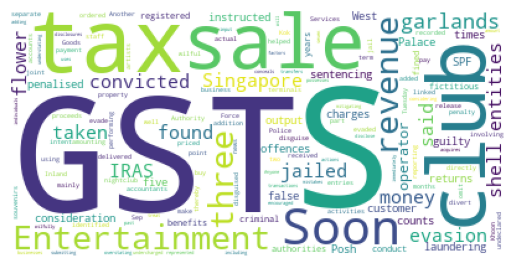

{'data': 'iVBORw0KGgoAAAANSUhEUgAAAZAAAADICAIAAABJdyC1AAEAAElEQVR4nOx9dXgbx9b32V0xs2RmxsSJ4zAzNE2aJuWUmzL3lm97S7fMlGLSpG3aBhtmduLEzMyWLVnM0u5+f8iVZVmWZce58H739+TJMzpzZnZWXp2dOYiQJAn/w//wP/wP/w2gXMngDp0hTMALwEACAX8JRATBruRaY4h9R8uWzM3w26Xs0Stk/COnqubNSBmryzkdLm2vSRYiGJPZ6qs641NCx2Sq/1gobT2PFb8QDOdTSQ+OF2Ze7fUMefWnfn7nnRvc7d27CwV81oyZyYGHdHZqQ0OFV39p/2dBAYDyzu56VW92eIjF4Sxq60pRSLsMRrPdkSATC5jM/KbW1BCZw4W3avVxEhGfyXBTKCj608WSO6bkOHHcPWp8pO8P6YzyH43Gg+729bF7mJh4zG+g1nAskTcneB61xnSpuGXS+NiislaL1RETKUFRpKlVHR8jQxBk+97CdddMbOvU7j5YEhMpYdCp5dUd8TEyHCc6lLrocHFa8oiFhd3m1Kr9CKzTh8qnzktFUXREs+3acv6J11aPdA2f1P65MjwvgiUJhrnD2hvGHOVfatixvQ7jWxW/vzPu9tHN/x8FBBBPW9NrSkhQBObXaMzb/7j04EPzr/K6rgiLf91UpVYBAJdGL7v7wat3oSeOHjjb1pK//t4RjaIAAIogBqudRaP+UVSRIBOXd3Y7cPyuqRM2ninIi4mUcTmXWjqkXPbEqLBIkaCso9tNWT95fLJCkiATv3fkjHvUYIHVZbk0VrentFZq7E0SRryTsOmdnSJaFAlkr73R4tKobHVKa4WEEU+QuLsLQ6huCgDi5vHMczq/LixEcDq/zmC03nr95N92XyZIcu01E7Zuv7j2mgnx0bKYKMnpC3UrFmb9tvuyRmeOiZTU1Ct5XGZ2WnhYyIB3o1Fv3fNLvtloS8mKHD85/tdvT7qc+N

In [11]:
# extract text & export NLP results as JSON
def run_chatterbox(filename):
    text = extract_text(filename)
    num_words = len(text.split(' '))
    num_sent = len(text.split('.'))
    requestJson = {"text": text}

    print("Total wordcount:", num_words)
    print("Total sentences:", num_sent)
    
    # Sentiment
    sentimentJson = generate_sentiments(requestJson)
    # Summary
    summarizedJson = generate_summary(requestJson)
    # Word Cloud
    wordcloudJson = generate_word_cloud(requestJson)
    
    finalJson = {**sentimentJson, **summarizedJson, **wordcloudJson}
    
    return finalJson

response = run_chatterbox("article.txt")
print(response)

In [ ]:
# Export individual text, sentiment and score into JSON
def export_sentiments_to_JSON(chunks, model, tokenizer):
        scores_table = []
        new_df = pd.DataFrame(columns=["Content","Sentiment", "Score"])
        for index in range(len(chunks)):
                text = chunks[index]
                encoded_input = tokenizer(text, return_tensors='pt')
                output = model(**encoded_input)
                scores = output[0][0].detach().tolist()
                scores = softmax(scores)    # converts into probabilities
                
                scores_table.append(scores)
                max_index = np.argmax(scores)
                pred_sentiment = labels[max_index]
                pred_score = scores[pred_sentiment]

                # write text and predicted data into df
                new_df.at[index, "Sentiment"] = pred_sentiment
                new_df.at[index, "Score"] = pred_score
                new_df.at[index, "Content"] = "".join((chunks[index]))
        new_df.to_json("backend/data/results.json")

OLD SENTINENT ANALYSIS METHOD WITH PIPELINE

In [ ]:
def generate_sentiments(messageJson):
    # sentiment analysis model
    # model = "siebert/sentiment-roberta-large-english"
    nlp = pipeline("sentiment-analysis", model=model, tokenizer=model)

    message = messageJson["text"]
    texts = message.split('.')
        
    print(texts, "\n\n")
    chunks = form_text_chunks(texts, 512)
    new_df = pd.DataFrame(columns=["Content","Sentiment", "Score"])

    for index in range(len(chunks)):
        preds = nlp(chunks[index])
        # print(preds)
        pred_sentiment = preds[0]["label"]
        pred_score = preds[0]["score"]

        # write predicted data into df
        new_df.at[index, "Sentiment"] = pred_sentiment
        new_df.at[index, "Score"] = pred_score
        # write text
        new_df.at[index, "Content"] = "".join((chunks[index]))

    # new_df.to_csv("backend/data/results.csv", index=False)
    new_df.to_json("backend/data/results.json")
    returnJson = {"sentiment": new_df}
    print(returnJson)
    return returnJson
    return None

### TEST CODE
test_filename = "article.txt"
text = extract_text(test_filename)
num_words = len(text.split(' '))
num_sent = len(text.split('.'))
print("Total wordcount:", num_words)
print("Total sentences:", num_sent)
requestJson = {"text": text}
sentimentJson = generate_sentiments(requestJson)
# print(sentimentJson)

In [ ]:
def generate_sentiment_graph(results):    
    # visualize the sentiments
    sentiment_counts = results.groupby(['Sentiment']).size()
    print(sentiment_counts)
    fig = plt.figure(figsize=(6,6), dpi=100)
    ax = plt.subplot(111)
    sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

generate_sentiment_graph(results)